Analysis of two-port RC data

VNA -> patch pannel -> antennas. Calibration plane is right before the antenna. Uses calibration file SOLT250M-1050M4501pt_4_14_25.cal (except High res which uses SOLT300M-320M4001pt_4_11_25.cal. This calibration may be bad). Big vivaldi is port 2. log periodic is port 1. 

The stirrer has 4800 steps per 360 degrees. This comes from 400 steps/rotation of the stepper motor, 4x microsteps, and a 3:1 gear ratio. 400 $\times$ 4 $\times$ 3 = 4800 steps/rev. We have invested a week in calibration using this number of microsteps, so it is hard coded and will likley never change

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget

# Plotting format 
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=16, labelsize=16)
plt.rc('legend', fontsize=14)
plt.rc('figure', titlesize=18)

directory = './data_gitignore/'

In [2]:
# Load the DataFrame from CSV
if 1: # high resolution = 5kHz. 300-320MHz span, 4000 frequency points. 
    # stirPos 1272 and 1896 dropped some frequency points! 
    df_HR   = pd.read_csv(directory 
        + "2portRcTest_300MHz_4_14_25_200Steps.csv")
    df_HR[["S11", "S12", "S22"]] = df_HR[["S11", "S12", "S22"]].astype(complex)       

if 1: # 177.8kHz resolution (sorry), 250-1050MHz, 4500 frequency points
    df      = pd.read_csv(directory 
        + "2portRcTest_250_1050MHz_200steps_4_14_25.csv")
    df[["S11", "S12", "S22"]] = df[["S11", "S12", "S22"]].astype(complex)  

    df_cp   = pd.read_csv(directory 
        + "2portRcTest_250_1050MHz_200steps_crossPolarizeVivaldi_4_14_25.csv")   # same as above, but vivaldi is cross polarized (by eye)
    df_cp[["S11", "S12", "S22"]] = df_cp[["S11", "S12", "S22"]].astype(complex)

if 1: # reprroducibility test. Same settings, taken one after another. 10 steps, 250-1050MHz
    df_rep1      = pd.read_csv(directory 
        + "10StepReproducibility_v1_4_15_25.csv")  
    df_rep1[["S11", "S12", "S22"]] = df_rep1[["S11", "S12", "S22"]].astype(complex)
    df_rep2      = pd.read_csv(directory 
        + "10StepReproducibility_v2_4_15_25.csv")  
    df_rep2[["S11", "S12", "S22"]] = df_rep2[["S11", "S12", "S22"]].astype(complex)
    df_rep3      = pd.read_csv(directory 
        + "10StepReproducibility_v3_4_15_25.csv")  
    df_rep3[["S11", "S12", "S22"]] = df_rep3[["S11", "S12", "S22"]].astype(complex)

#print(df_rep1.head())
#print(df_rep2.head())

In [3]:
# The VNA sometimes drops frequency points. Not that big of an issue, but should know about it. 
# check how many freq points.

for stirPos, group in df_HR.groupby("stirPos"):
    freq_array = group["Freq_MHz"].values  # Get the frequency array as a numpy array
    if len(freq_array) != 4001:
        print(f"ERROR!!! stirPos {stirPos}: {len(freq_array)} frequency points at stirPos = {stirPos}")
    #print(f"stirPos {stirPos}: {len(freq_array)} frequency points")
    

ERROR!!! stirPos 1272: 3652 frequency points at stirPos = 1272
ERROR!!! stirPos 1896: 3685 frequency points at stirPos = 1896


In [4]:
#functions

def get_s_at_frequency(target_freq, df, s_parameter, printFreq = True):
    """
    Extracts and returns an array of S-parameter values (complex) from the DataFrame at the frequency
    closest to the given target_freq.
    Prints the actual frequency used. 
    
    Parameters:
      target_freq (float): The target frequency (in MHz) for which S-parameter values are needed.
      df (pd.DataFrame): The DataFrame containing the data. This DataFrame is expected to
                         have columns "Sweep time", "Freq_MHz", "S12", "S11", and "S22".
        s_parameter (string): s-parameter to be extracted. accepts S11, S22 or S12. 
                         
    Returns:
      stirPos (np.ndarray): array of stirrer position in units of steps from zero
      S_parameter (np.ndarray): Array of S-parameter values (complex) corresponding to the frequency closest to target_freq,
                  one per unique "Sweep time" in the DataFrame.
    """
    s_values = []
    
    # Group the dataframe by "Sweep time", so that each group represents a separate sweep.
    groups = df.groupby("stirPos")
    # For each sweep, find the row where Freq_MHz is closest to target_freq.
    for sweep_time, group in groups:
        # Calculate the absolute difference between the frequencies and target_freq.
        diff = (group["Freq_MHz"] - target_freq).abs()
        # Get the index of the smallest difference.
        closest_index = diff.idxmin()
        # Extract the S12 value at that index.
        s_val = group.loc[closest_index, s_parameter]
        # Ensure the value is a complex number (if it's a string, convert it).
        if isinstance(s_val, str):
            s_val = complex(s_val)
        s_values.append(s_val)
    if printFreq == True:
        print("Closest frequency:", group.loc[closest_index, "Freq_MHz"], "MHz")
    return pd.unique(df['stirPos']), np.array(s_values)



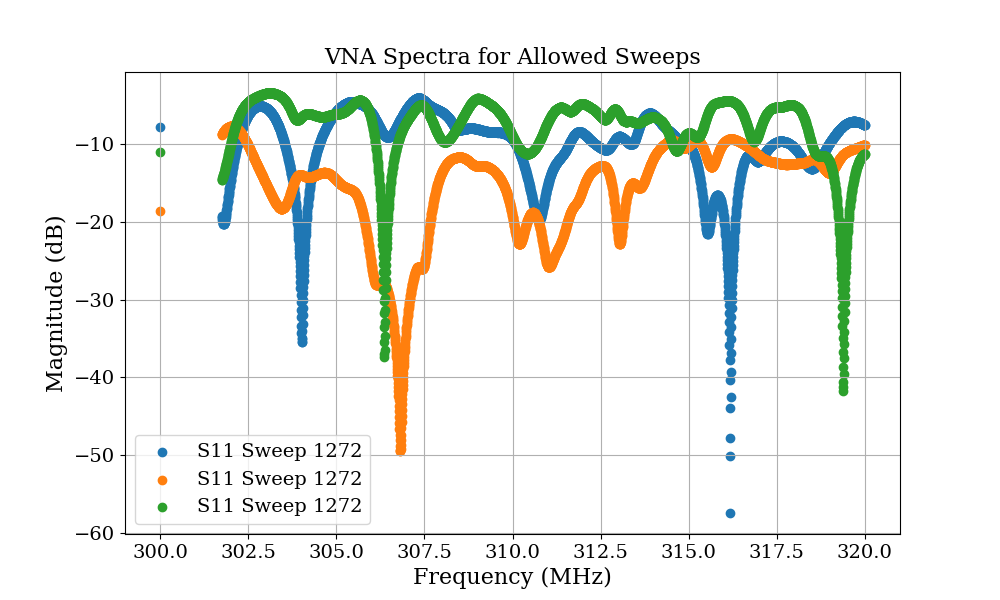

In [74]:
#general plotting of S vs freq for a given list of positions

# Specify the list of sweeps you want to plot.
posArr = [1272]

# Create a new figure.
plt.figure(figsize=(10, 6))

# Group the data by sweep number and plot only the selected sweeps.
for sweep, group in df_HR.groupby("stirPos"):
    if sweep not in posArr:
        continue  # Skip sweeps that are not in the allowed list
    freqs = group["Freq_MHz"]    
    plt.scatter(freqs, 20*np.log10(np.abs(group["S11"])), label=f"S11 Sweep {sweep}")
    plt.scatter(freqs, 20*np.log10(np.abs(group["S12"])), label=f"S11 Sweep {sweep}")
    plt.scatter(freqs, 20*np.log10(np.abs(group["S22"])), label=f"S11 Sweep {sweep}")

# Label the plot appropriately.
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("VNA Spectra for Allowed Sweeps")
plt.legend()
plt.grid(True)
plt.show()

Closest frequency: 306.0 MHz
Closest frequency: 306.0 MHz
Closest frequency: 306.0 MHz
Closest frequency: 306.0 MHz
Closest frequency: 306.0 MHz
Closest frequency: 306.0 MHz


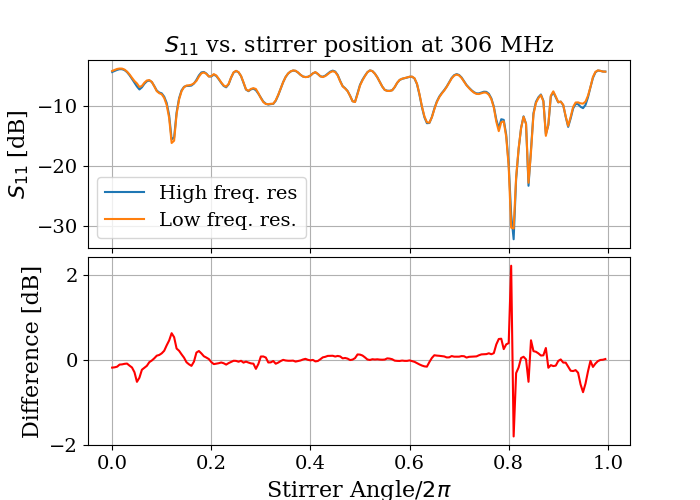

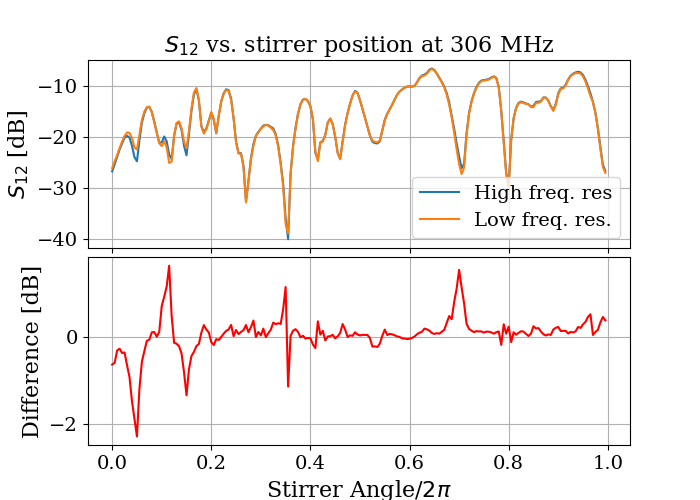

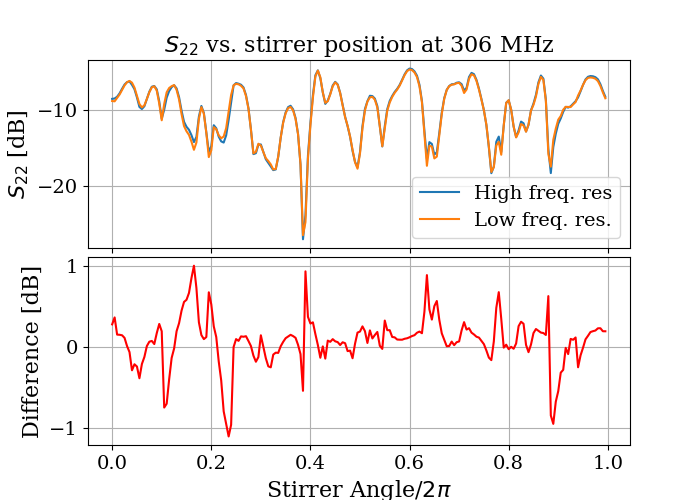

In [75]:
# Are positions reproducible? 
#In this cell, we compare the high res (300-320MHz) and low res (250-1050MHz) scan. These should be the same. 
freq = 306 # note, different resolutions. 301.2, 304.4, 306 ..., 318.8 MHz show up exactly in both resolutions
                # 301.2 is bad!!!!! stirPos = 1278 and 1896 drop the first few hundred frequency points in the high res. VNA error
plt.close('all')
#S11
posArr, S11_HR  = get_s_at_frequency(freq, df_HR, "S11")
posArr, S11      = get_s_at_frequency(freq, df, "S11")
#S12
posArr, S12_HR  = get_s_at_frequency(freq, df_HR, "S12")
posArr, S12      = get_s_at_frequency(freq, df, "S12")
#S22
posArr, S22_HR  = get_s_at_frequency(freq, df_HR, "S22")
posArr, S22      = get_s_at_frequency(freq, df, "S22")


#plot s11
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S11 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S11_HR)), label='High freq. res')
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S11)), label='Low freq. res.')
axs[0].set_title(f'$S_{{11}}$ vs. stirrer position at {freq} MHz')
axs[0].set_ylabel(r'$S_{11}$ [dB]')
axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S11_HR)) - 20*np.log10(np.abs(S11))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)

plt.subplots_adjust(hspace=0.05)
plt.show()


#plot s12
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S12 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S12_HR)), label='High freq. res')
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S12)), label='Low freq. res.')
axs[0].set_title(f'$S_{{12}}$ vs. stirrer position at {freq} MHz')
axs[0].set_ylabel(r'$S_{12}$ [dB]')
axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S12_HR)) - 20*np.log10(np.abs(S12))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)

plt.subplots_adjust(hspace=0.05)
plt.show()

#plot s22
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S22 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S22_HR)), label='High freq. res')
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S22)), label='Low freq. res.')
axs[0].set_title(f'$S_{{22}}$ vs. stirrer position at {freq} MHz')
axs[0].set_ylabel(r'$S_{22}$ [dB]')
axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S22_HR)) - 20*np.log10(np.abs(S22))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)

plt.subplots_adjust(hspace=0.05)
plt.show()

Closest frequency: 280.044444 MHz
Closest frequency: 280.044444 MHz
Closest frequency: 280.044444 MHz
Closest frequency: 280.044444 MHz
Closest frequency: 280.044444 MHz
Closest frequency: 280.044444 MHz


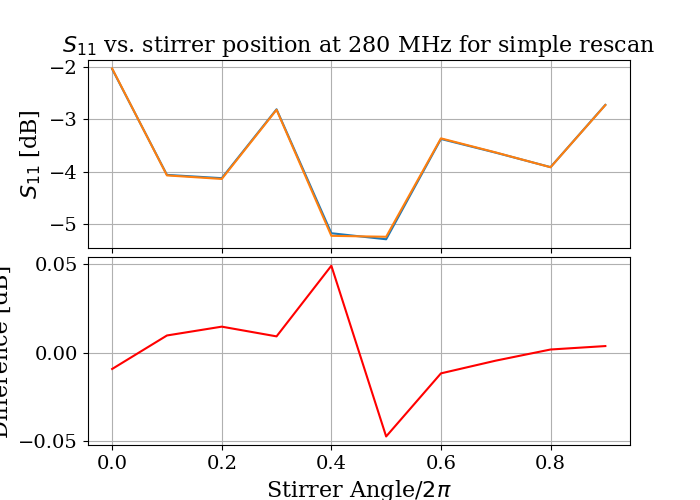

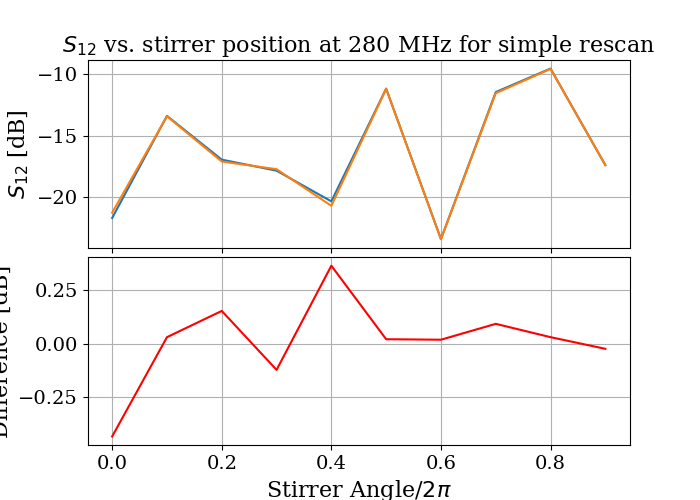

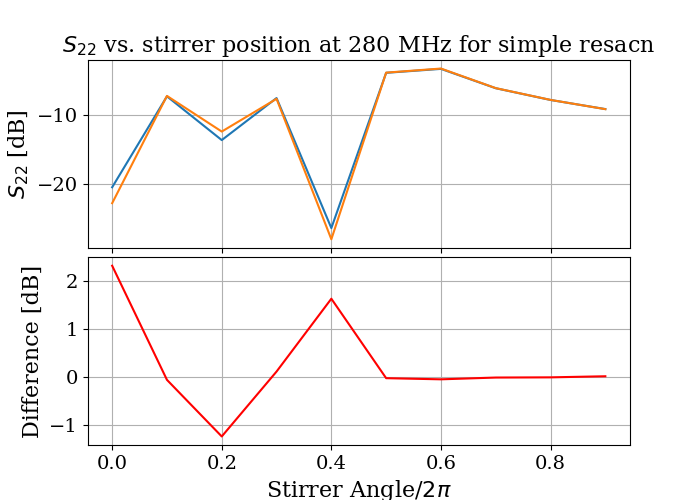

In [76]:
#Same as above by for better controlled data. Only 10 stirPos. 3 scans run right after each other (df_rep{1,2,3})

freq = 280 # note, different resolutions. 301.2, 304.4, 306 ..., 318.8 MHz show up exactly in both resolutions
                # 301.2 is bad!!!!! stirPos = 1278 and 1896 drop the first few hundred frequency points in the high res. VNA error
plt.close('all')
#S11
posArr, S11_HR  = get_s_at_frequency(freq, df_rep1, "S11")
posArr, S11      = get_s_at_frequency(freq, df_rep2, "S11")
#S12
posArr, S12_HR  = get_s_at_frequency(freq, df_rep1, "S12")
posArr, S12      = get_s_at_frequency(freq, df_rep2, "S12")
#S22
posArr, S22_HR  = get_s_at_frequency(freq, df_rep1, "S22")
posArr, S22      = get_s_at_frequency(freq, df_rep2, "S22")


#plot s11
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S11 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S11_HR)), label='High freq. res')
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S11)), label='Low freq. res.')
axs[0].set_title(f'$S_{{11}}$ vs. stirrer position at {freq} MHz for simple rescan')
axs[0].set_ylabel(r'$S_{11}$ [dB]')
#axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S11_HR)) - 20*np.log10(np.abs(S11))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)

plt.subplots_adjust(hspace=0.05)
plt.show()


#plot s12
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S12 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S12_HR)), label='High freq. res')
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S12)), label='Low freq. res.')
axs[0].set_title(f'$S_{{12}}$ vs. stirrer position at {freq} MHz for simple rescan')
axs[0].set_ylabel(r'$S_{12}$ [dB]')
#axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S12_HR)) - 20*np.log10(np.abs(S12))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)

plt.subplots_adjust(hspace=0.05)
plt.show()

#plot s22
fig, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)

# Top subplot: S22 data plot.
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S22_HR)), label='High freq. res')
axs[0].plot(posArr/4800, 20*np.log10(np.abs(S22)), label='Low freq. res.')
axs[0].set_title(f'$S_{{22}}$ vs. stirrer position at {freq} MHz for simple resacn')
axs[0].set_ylabel(r'$S_{22}$ [dB]')
#axs[0].legend()
axs[0].grid(True)

# Bottom subplot: residual plot.
residual = 20*np.log10(np.abs(S22_HR)) - 20*np.log10(np.abs(S22))
axs[1].plot(posArr/4800, residual, color='red')
axs[1].set_xlabel(r'Stirrer Angle/$2\pi$')
axs[1].set_ylabel('Difference [dB]')
axs[1].grid(True)

plt.subplots_adjust(hspace=0.05)
plt.show()

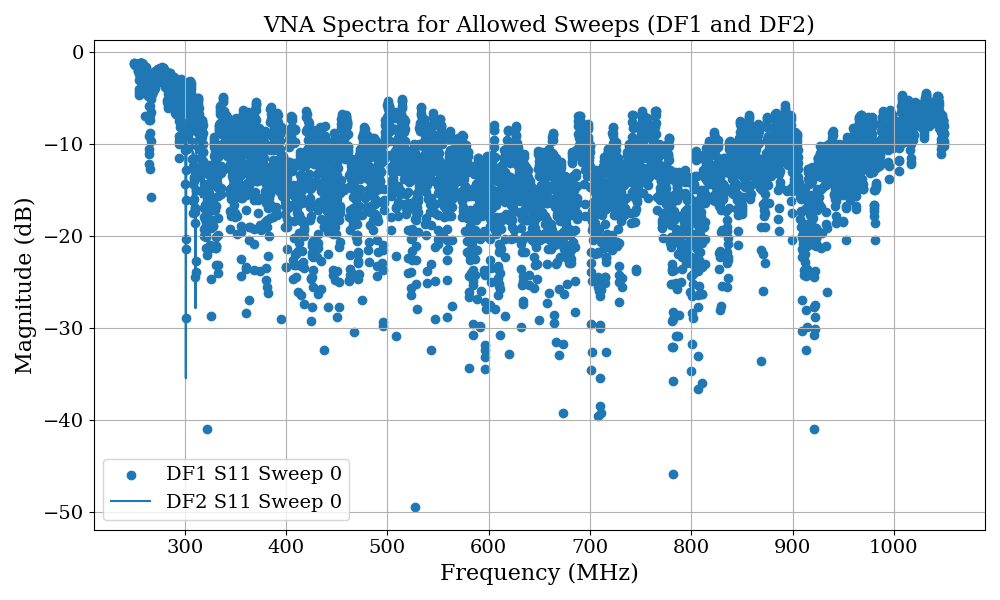

In [72]:
#Compare resolutions

import matplotlib.pyplot as plt
import numpy as np

# Specify the list of sweeps you want to plot.
allowed_sweeps = [0]

plt.figure(figsize=(10, 6))

# Plot data from df1.
for sweep, group in df.groupby("stirPos"):
    if sweep not in allowed_sweeps:
        continue  # skip sweeps not in the allowed list
    freqs = group["Freq_MHz"]
    s11_complex = group["S11"].apply(lambda x: complex(x) if isinstance(x, str) else x)
    s11_db = 20 * np.log10(np.abs(s11_complex))
    plt.scatter(freqs, s11_db, label=f"DF1 S11 Sweep {sweep}")
    #plt.plot(freqs, s22_db, marker='s', linestyle='-', label=f"DF1 S22 Sweep {sweep}")

# Plot data from high res.
for sweep, group in df_HR.groupby("stirPos"):
    if sweep not in allowed_sweeps:
        continue
    freqs = group["Freq_MHz"]
    s11_complex = group["S11"].apply(lambda x: complex(x) if isinstance(x, str) else x)
    s11_db = 20 * np.log10(np.abs(s11_complex))
    plt.plot(freqs, s11_db, label=f"DF2 S11 Sweep {sweep}")
    #plt.plot(freqs, s22_db, marker='s', linestyle='--', label=f"DF2 S22 Sweep {sweep}")

plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude (dB)")
plt.title("VNA Spectra for Allowed Sweeps (DF1 and DF2)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The following few cells perform some testing to compute the number of independent positions

Closest frequency: 250.0 MHz
Closest frequency: 600.044444 MHz
Closest frequency: 800.044444 MHz
Closest frequency: 1000.044444 MHz


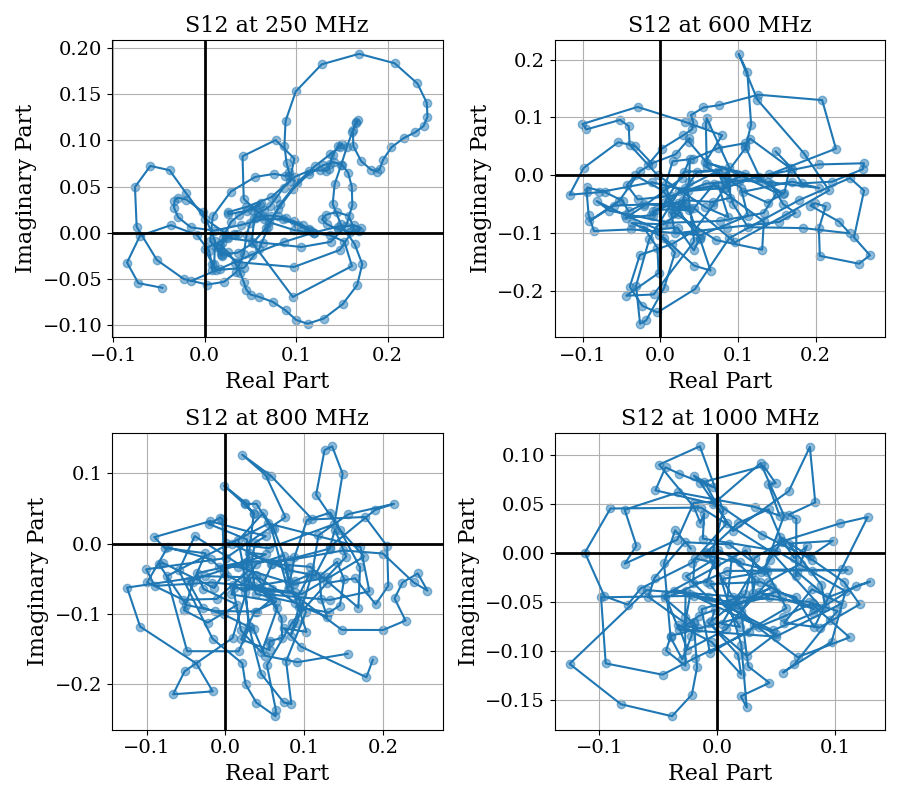

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Specify the list of target frequencies (in MHz).
target_freqs = [250, 600, 800, 1000]

# Prepare a list to hold the S12 arrays.
s12_arrays = []

# Get S12 data for each frequency.
for f in target_freqs:
    none, s12_array = get_s_at_frequency(f, df, "S12")
    s12_arrays.append(s12_array)

# Create a 2x2 grid of subplots.
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
axs = axs.flatten()  # Flatten to a single list for easier iteration.

# Loop over the target frequencies and corresponding S12 arrays.
for i, f in enumerate(target_freqs):
    s12_arr = s12_arrays[i]
    axs[i].plot(np.real(s12_arr), np.imag(s12_arr))
    axs[i].scatter(np.real(s12_arr), np.imag(s12_arr), alpha = .5)
    axs[i].set_xlabel("Real Part")
    axs[i].set_ylabel("Imaginary Part")
    axs[i].set_title(f"S12 at {f} MHz")
    axs[i].grid(True)
    # Add bold lines at the origin (0,0)
    axs[i].axhline(y=0, color='black', linewidth=2)
    axs[i].axvline(x=0, color='black', linewidth=2)
    

plt.tight_layout()
plt.show()


Closest frequency: 299.955555 MHz
[-0.132742  +0.422859j  -0.0941305 +0.444781j  -0.0586502 +0.448391j
 -0.0161957 +0.450332j   0.0124827 +0.451552j   0.0256238 +0.463007j
  0.0165698 +0.48742j   -0.0167214 +0.518297j  -0.0794938 +0.541608j
 -0.156111  +0.50676j   -0.170026  +0.453738j  -0.190365  +0.434927j
 -0.234062  +0.419825j  -0.291337  +0.406751j  -0.353905  +0.400997j
 -0.416601  +0.41226j   -0.464334  +0.433349j  -0.494052  +0.466546j
 -0.50321   +0.503489j  -0.496432  +0.537294j  -0.478423  +0.566942j
 -0.441097  +0.591613j  -0.381804  +0.593913j  -0.333244  +0.557878j
 -0.330029  +0.518121j  -0.343896  +0.509475j  -0.349452  +0.518445j
 -0.34833   +0.530804j  -0.338194  +0.539289j  -0.320778  +0.543358j
 -0.301387  +0.548109j  -0.281472  +0.55201j   -0.266588  +0.555527j
 -0.257739  +0.569714j  -0.253785  +0.584128j  -0.257323  +0.588205j
 -0.268576  +0.59668j   -0.291048  +0.584154j  -0.316957  +0.569847j
 -0.351954  +0.535741j  -0.386094  +0.492715j  -0.420253  +0.448129j


/home/dradmin/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


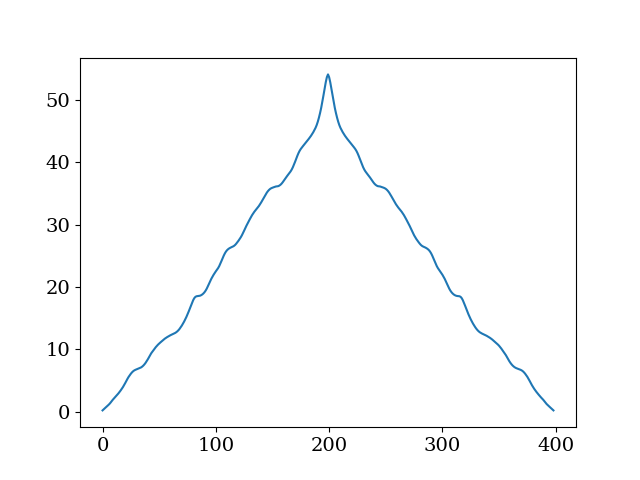

In [88]:
stirPosArr, S11 = get_s_at_frequency(300, df, "S11")
print(S11)
ac_S11 = np.correlate(S11, S11, 'full')
print(ac_S11)
plt.figure()
plt.plot(ac_S11)

In [119]:
x = [1,2,3]
np.roll(x, 2)

array([2, 3, 1])

Closest frequency: 260.666666 MHz


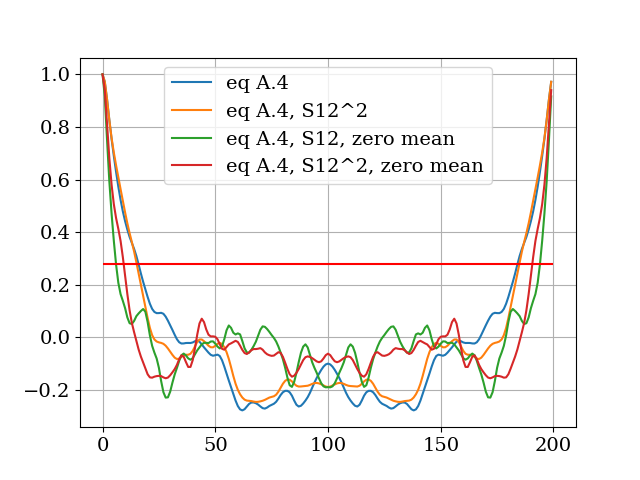

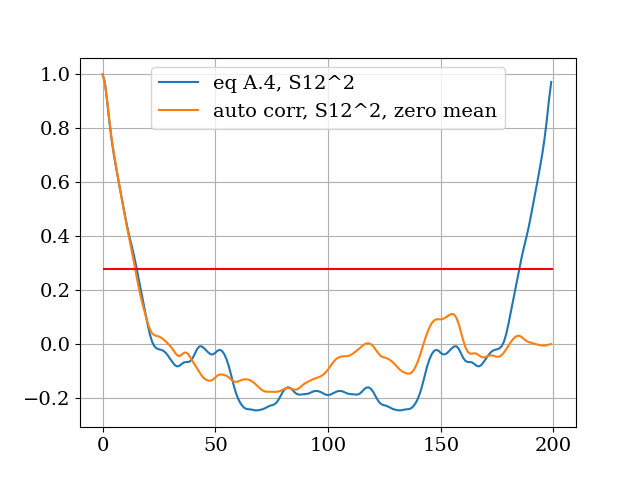

In [20]:
import numpy as np

def tuner_efficiency_autocorr(S12):
    """
    Implements IEC 61000-4-21 Annex A.3 (Equation A.4) for
    tuner efficiency/autocorrelation at a single frequency.

    Parameters
    ----------
    S12 : np.ndarray
        1D array (length N) of complex S12 measurements,
        one value per stirrer position.

    Returns
    -------
    r_array : np.ndarray
        1D array (length N) of correlation coefficients r(k),
        for circular shifts k = 0, 1, ..., N-1.
        r_array[0] should be 1.0 (perfect correlation at zero shift).
    """
    # 1) Convert to power-like data: x[i] = |S12[i]|^2
    x = np.abs(S12)
    N = len(x)
    #x_mean = x.mean()
    #x_zeromean = x - x_mean
    
    # 2) Precompute the mean and denominator portion for x
    ux = np.mean(x)
    sum_sq_x = np.sum((x - ux)**2)
    
    # Prepare output
    r_array = np.zeros(N, dtype=float)
    
    # 3) Loop over all possible shifts k
    for k in range(N):
        # Circularly shift x by k steps
        y = np.roll(x, -k)  # negative sign just a convention; either way is fine
        uy = np.mean(y)
        
        # Numerator: sum over i of (x_i - u_x)*(y_i - u_y)
        numerator = np.sum((x - ux) * (y - uy))
        
        # Denominator: sqrt( sum((x-ux)^2) * sum((y-uy)^2) )
        # But note y is just x shifted, so sum((y-uy)^2) = sum((x-ux)^2).
        sum_sq_y = np.sum((y - uy)**2)
        denom = np.sqrt(sum_sq_x * sum_sq_y)
        
        # Avoid division by zero if data is degenerate
        if denom == 0:
            r_array[k] = 0.0
        else:
            r_array[k] = numerator / denom
    
    return r_array

def autocorr_coeff(x):
    """
    Returns the normalized linear autocorrelation of x for lags 0..(N-1).
    The result at each lag is in [-1, +1], analogous to a correlation coefficient.
    """
    x = np.asarray(x)
    N = len(x)
    # Subtract mean so that a purely constant signal doesn't skew results
    x_mean = x.mean()
    x_zeromean = x - x_mean
    
    # Full cross-correlation, length 2*N-1
    raw_corr = np.correlate(x, x, mode="full")
    
    # The zero-lag index is at N-1
    # We only want lags from 0 to N-1 (no negative lags for autocorrelation).
    # That portion is raw_corr[N-1 : ]
    # But we must normalize each lag by the product of the vector norms.
    # For lag k, the overlap length is (N - k).
    
    # Denominator for zero-lag (variance * overlap length).
    # Here we can store the total energy for the entire signal:
    total_energy = np.sum(x**2)
    
    r = []
    # For each lag k in [0..N-1], the index in raw_corr is (N-1 + k).
    for k in range(N):
        numerator = raw_corr[N-1 + k]  # sum of x[i]*x[i+k] over the overlap
        # Overlap length is (N-k)
        # The "energy" in that overlap is less than total_energy,
        # so if you want the correlation coefficient, you can do a partial normalization.
        # But the typical approach: 
        # We'll just normalize by total_energy for zero-lag to get a 1.0 at k=0. 
        # Another approach: partial window = sum over i=0..(N-k-1) of x[i]^2
        # which might get more complicated. 
        # For a standard definition, let's just do:
        denom = total_energy  
        
        # correlation coefficient at lag k
        r_k = numerator / denom if denom != 0 else 0
        r.append(r_k)
    
    return np.array(r)


stirPosArr, S12 = get_s_at_frequency(260.665, df, "S12")
r = 0.37 * (1 - (7.22/len(S12)**0.64))

plt.close('all')
plt.figure()
plt.plot(tuner_efficiency_autocorr(S12), label = 'eq A.4')
plt.plot(tuner_efficiency_autocorr(np.abs(S12)**2), label = 'eq A.4, S12^2')
plt.plot(tuner_efficiency_autocorr((np.abs(S12))- np.mean(np.abs(S12))), label = 'eq A.4, S12, zero mean')
plt.plot(tuner_efficiency_autocorr((np.abs(S12)**2)- np.mean(np.abs(S12)**2)), label = 'eq A.4, S12^2, zero mean')
#plt.plot(tuner_efficiency_autocorr(np.random.normal(0,1,200)))
#x = abs(S12)**2
#plt.plot(autocorr_coeff(x))
plt.hlines(r, 0, len(stirPosArr), 'r')
plt.grid()
plt.legend()


plt.figure()
plt.plot(tuner_efficiency_autocorr((np.abs(S12)**2)), label = 'eq A.4, S12^2')
plt.plot(autocorr_coeff((np.abs(S12)**2)- np.mean(np.abs(S12)**2)), label = 'auto corr, S12^2, zero mean')
#plt.plot(tuner_efficiency_autocorr(np.random.normal(0,1,200)))
#x = abs(S12)**2
#plt.plot(autocorr_coeff(x))
plt.hlines(r, 0, len(stirPosArr), 'r')
plt.grid()
plt.legend()

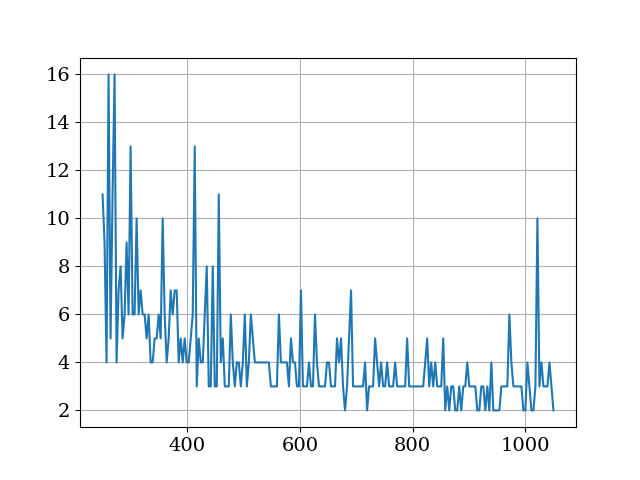

In [22]:
freqs = pd.unique(df["Freq_MHz"])
r = 0.37 * (1 - (7.22/len(S12)**0.64))
numPos = []

for freq in freqs[::20]:
    print(freq)
    stirPosArr, S12 = get_s_at_frequency(freq, df, "S12", printFreq=False)
    rArr = tuner_efficiency_autocorr(np.abs(S12)**2)
    #print(np.where(rArr < r)[0][0])
    numPos.append(np.where(rArr < r)[0][0])


plt.figure()
plt.plot(freqs[::20], numPos)
plt.grid()

Closest frequency: 299.955555 MHz


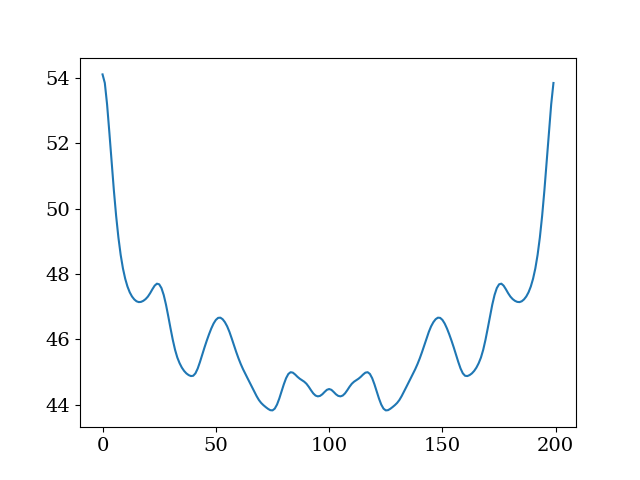

In [97]:
import numpy as np

def circular_autocorrelation(signal):
    """
    Returns the circular autocorrelation of 'signal' using the FFT method.
    
    Parameters
    ----------
    signal : array-like
        1D array (real or complex) of length N.
    
    Returns
    -------
    acorr : np.ndarray
        1D array of length N containing the circular autocorrelation.
        acorr[k] = sum over n of signal[n]*conj(signal[(n+k) mod N]).
    """
    N = len(signal)
    # Take the FFT
    fft_vals = np.fft.fft(signal)
    # Multiply by complex conjugate to get power spectrum
    power_spectrum = fft_vals * np.conj(fft_vals)
    # IFFT -> circular autocorrelation in time domain
    acorr = np.fft.ifft(power_spectrum)
    # Usually you only want the real part (imag part ~ numerical noise)
    acorr = acorr.real
    return acorr

# Example usage:
# Suppose S11 is a length-200 array of complex data
# S11_circ_acorr = circular_autocorrelation(S11)

# You can inspect the zero-lag (acorr[0]) and other lags:
# print(S11_circ_acorr)

stirPosArr, S11 = get_s_at_frequency(300, df, "S11")
plt.figure()
plt.plot(circular_autocorrelation(S11))